<a href="https://colab.research.google.com/github/HSYhrae/TIL/blob/master/ML230823.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,645 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline


In [ ]:
import lightgbm
lightgbm.__version__

'3.3.2'

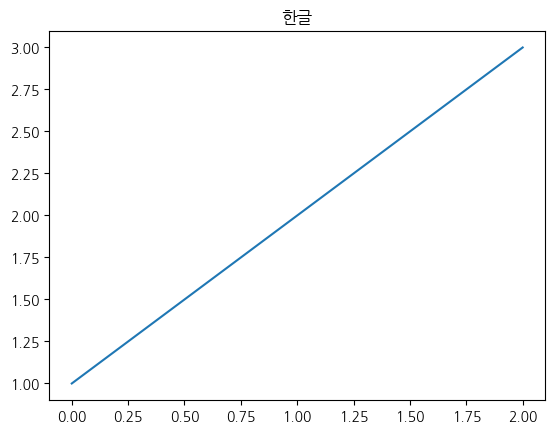

In [ ]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

### 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 0. 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Step 1. 데이터 불러오기

In [ ]:
bike_df = pd.read_csv('/content/drive/MyDrive/멀티캠퍼스 국비지원 교육/정지훈 강사님 수업/머신러닝&딥러닝/data/ch05_data/ch05_data/bike_train.csv')
pritn(bike_df.shape)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


### Step 02. 데이터 가공 & EDA


In [ ]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis = 1, inplace = True)

bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


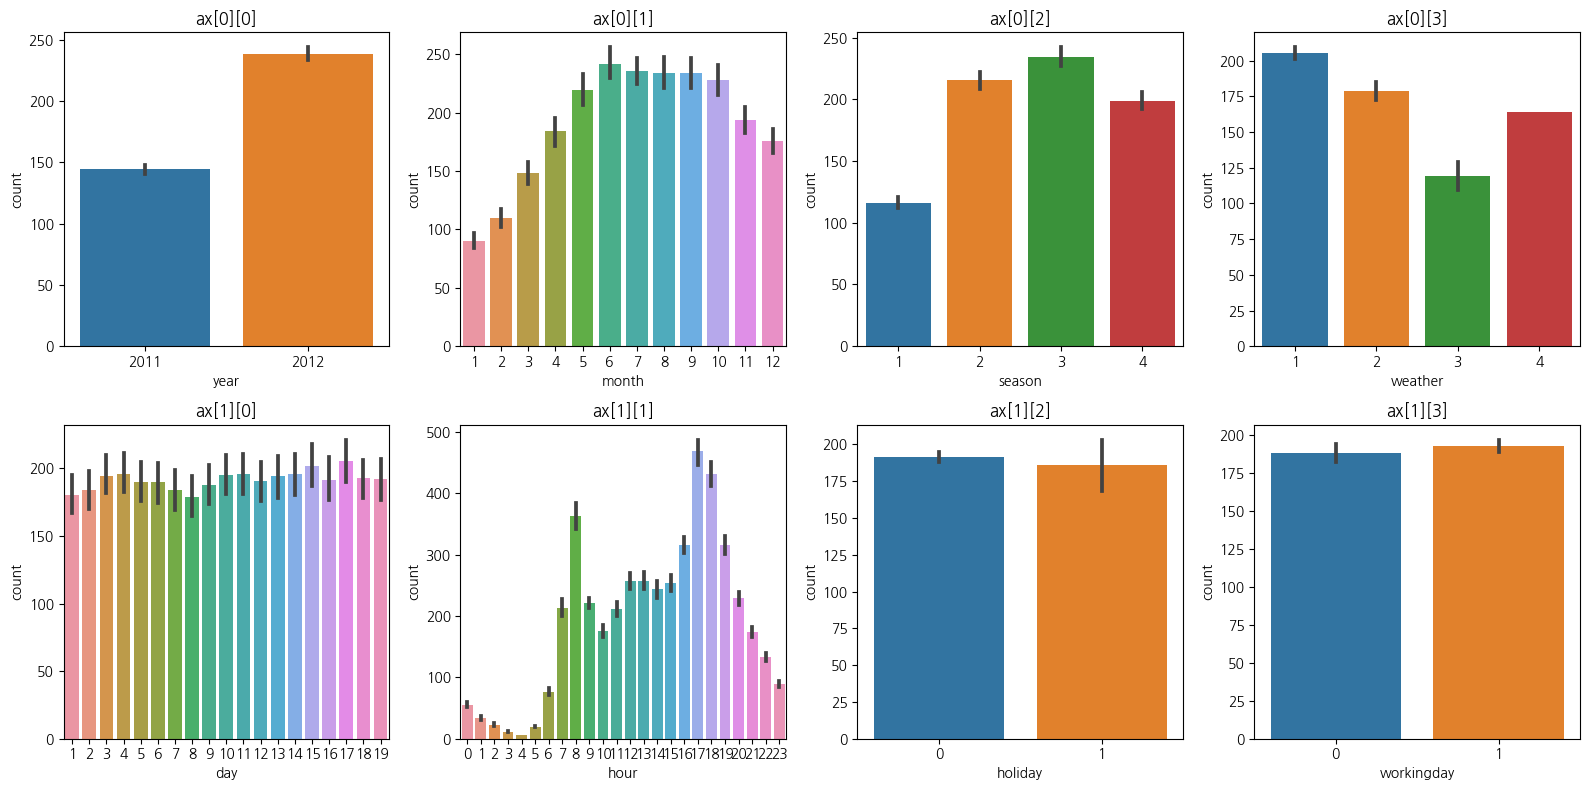

In [ ]:
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
fig, ax = plt.subplots(figsize = (16, 8), ncols = 4, nrows = 2)
for i, feature in enumerate(cat_features):
    row = int(i/4) # 몫, 0과1
    col = i%4 # 나머지 0, 1, 2, 3
    sns.barplot(x = feature, y = 'count', data = bike_df, ax = ax[row][col])
    ax[row][col].set_title(f'ax[{row}][{col}]')
plt.tight_layout()
plt.show()

### Step 03. 평가지표 구현
- RMSLE: scikit-learn에서는 미제공
- RMSLE 함수를 만듦

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN등의 이슈로 log() 사용안함, log1p() 사용함
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2 # 제곱
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# mean_squared_error() 이용해서 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### Step 04. 로그 변환, 피처 인코딩, 모델 학습

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 정규화, 표준화 작업 선 진행 필요함
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7620, 12), (3266, 12), (7620,), (3266,))

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


- p368 ~ p374: 모델 성능 업그레이드
- 강사님이 하고 싶은 말:(머신러닝 과정)
    1. 베이스라인 모델 구축(데이터 가공 최소화, 아무것도 하지 않은 데이터 활용해서 가장 심플한 모형을 만들고 평가) 즉 기준점이 됨
    2. 데이터 가공 / 로그변환 / 하이퍼 파라미터 튜닝 (한번에 이 3과정을 처리하지 말것 -> 어떤 과정이 평가 지표를 좋게 만드는지 모르게 되므로 하나씩 그리고 2개씩 적용하고 성능이 변화하는것 기록)
    3. 프로젝트에는 이러한 과정들을 녹여내야 함
     

### Step 05. 모델 평가

In [ ]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending = False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

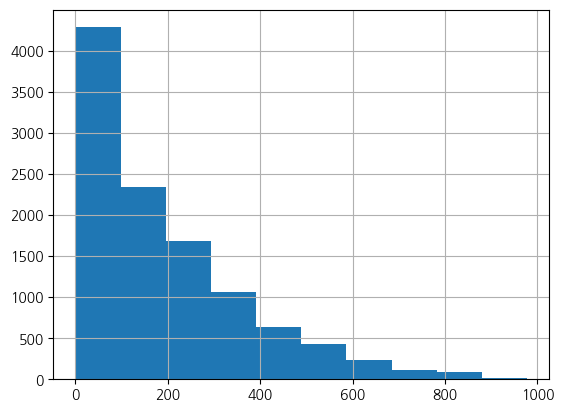

In [ ]:
y_target.hist() # 정규분포가 아닌 0~200사이로 값이 왜곡되어 예측값이 하나만 틀려도 왜곡이 커진다.

### Step 06. 종속변수 로그 변환

<Axes: >

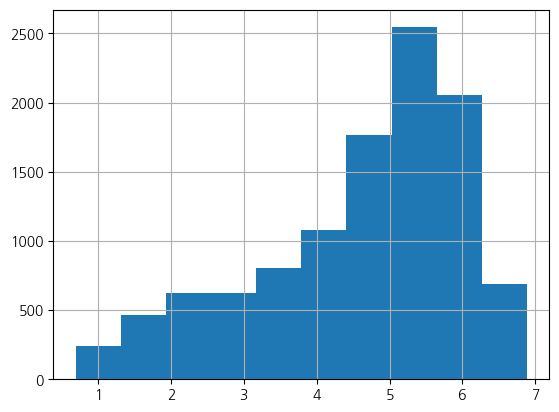

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

### Step 07. 모델 재구축

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 정규화, 표준화 작업 선 진행 필요함
y_target_log = np.log1p(y_target)
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 0)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

# 테스트 데이터 세트의 타겟값을 로그 변환
# evaluate_regr(y_test, pred) # 최초 진행시 원래 값으로 변환하는 과정을 거치지 않아 크게 향상된 것처럼 보인다. RMSLE: 0.232, RMSE: 1.017, MAE: 0.801

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- 각 피처의 회귀계수 값 시각화

<Axes: >

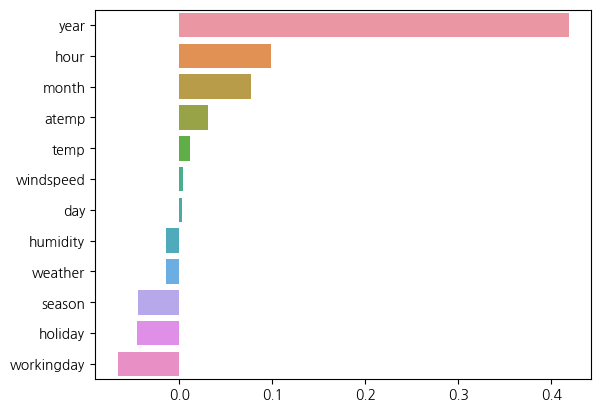

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
# year, hour, month, day, weather, season, holiday, workingday는 숫자 데이터가 아닌데 숫자처럼 인식하여 값이 왜곡됨

### Step 08. 변수 인코딩 변환

In [ ]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding 해줌
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

### Step 09. 모델 재구축2
- 기존 인코딩 변환
- 3개의 모델을 비교 분석 하겠다.

In [ ]:
# 테스트 / 후련 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False): # 지수변환
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1: # 지수변환 요청
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: >

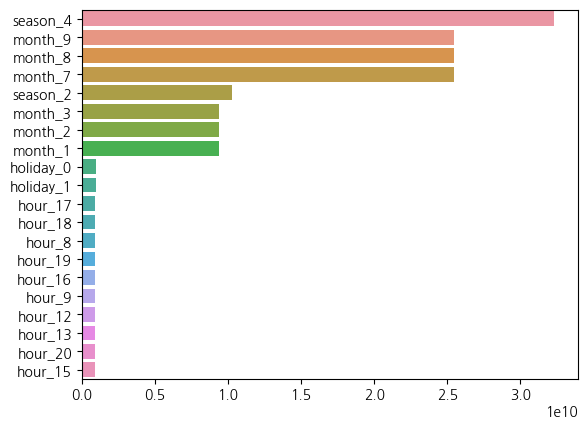

In [ ]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.201, MAE: 31.094
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.354, MAE: 32.755
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
